In [1]:
# import packages
import pandas as pd
import numpy as np
from numpy.random import seed
import tensorflow as tf
from tensorflow import set_random_seed
from tensorflow import keras
from tensorflow.keras.models import Model
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.linalg import orthogonal_procrustes
from numpy import linalg
from scipy.stats import zscore
from scipy.stats import norm
from sklearn.decomposition import PCA
seed(1)
set_random_seed(1)

In [2]:
# load data
# retrieved from https://openpsychometrics.org/_rawdata/
dat = pd.read_csv('E:/py/nonlinear_personality/IPIP-FFM-data-8Nov2018/data-final.csv', sep='\t')
dat = dat.iloc[:,:50]  # filters out variables except items
dat = dat.loc[dat.min(1)!=0,]  # filters out missing values (0s)
dat = (dat-1)/4 # transform to 0-1 scale
dat.dropna(inplace=True)
dat.shape

(874434, 50)

In [3]:
# reverse score
revd = [2, 4, 6, 8, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 23, 25, 27, 32, 34, 36, 38, 42, 44, 46]
revd = [r-1 for r in revd]
for r in revd:
    dat.iloc[:,r] = 1-dat.iloc[:,r]

In [4]:
# split data
train = dat.sample(frac=.9)
test = dat.drop(train.index)

In [5]:
# score 'appropriately' (mean of items)
trainScored = pd.concat([train.iloc[:,:10].mean(1),
             train.iloc[:,10:20].mean(1),
             train.iloc[:,20:30].mean(1),
             train.iloc[:,30:40].mean(1),
             train.iloc[:,40:50].mean(1)],axis=1)

testScored = pd.concat([test.iloc[:,:10].mean(1),
             test.iloc[:,10:20].mean(1),
             test.iloc[:,20:30].mean(1),
             test.iloc[:,30:40].mean(1),
             test.iloc[:,40:50].mean(1)],axis=1)

In [6]:
# establish baseline by using mean factor scores
ffmeans = trainScored.mean(0)
ffmeanpred = np.repeat(np.ndarray((1,50),buffer=np.array(np.repeat(ffmeans,10))),test.shape[0],axis=0)
np.sqrt(np.mean(np.mean(np.square(test-ffmeanpred)))) # RMSE

0.3053383918976558

In [7]:
# individual scoring performance
ffind = np.repeat(np.array(testScored),10,1)
np.sqrt(np.mean(np.mean(np.square(test-ffind)))) # RMSE

0.23496716050890606

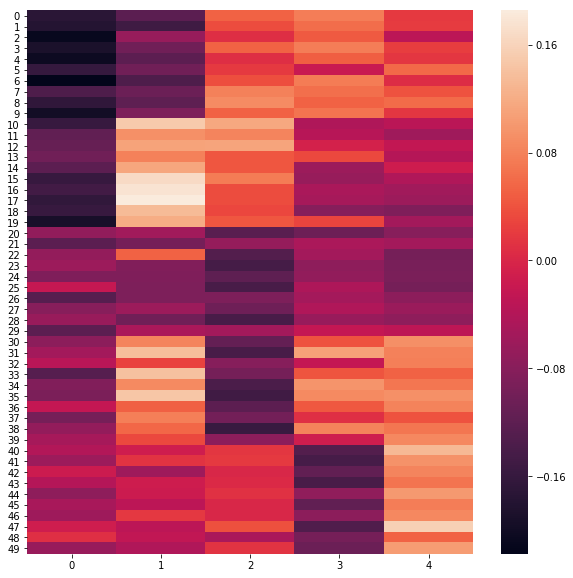

In [8]:
# perform PCA on training data
trainpca = PCA(n_components=5,)
trainpca.fit(train)
plt.figure(figsize=(10, 10))
sns.heatmap(trainpca.components_.T * np.sqrt(trainpca.explained_variance_))

In [9]:
# apply PCA to test data and evaluate fit
testscores = trainpca.transform(test)
ffpca = trainpca.inverse_transform(testscores)
np.sqrt(np.mean(np.mean(np.square(test-ffpca)))) # RMSE

0.2147317926200739

In [10]:
# define autoencoder
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(50, activation=tf.nn.relu,input_shape=[train.shape[1]]),
    keras.layers.Dense(50, activation=tf.nn.relu),
    keras.layers.Dense(50, activation=tf.nn.relu),
    keras.layers.Dense(50, activation=tf.nn.relu),
    keras.layers.Dense(5, activation=tf.nn.relu, name="code"),
    keras.layers.Dense(50, activation=tf.nn.relu),
    keras.layers.Dense(50, activation=tf.nn.relu),
    keras.layers.Dense(50, activation=tf.nn.relu),
    keras.layers.Dense(50, tf.nn.sigmoid)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_squared_error'])
  return model
model = build_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
code (Dense)                 (None, 5)                 255       
_________________________________________________________________
dense_4 (Dense)              (None, 50)                300       
______________________

In [11]:
# fit autoencoder
model.fit(train, train, epochs=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/2
786991/786991 [==============================] - 109s 139us/sample - loss: 0.0465 - mean_squared_error: 0.0465
Epoch 2/2
786991/786991 [==============================] - 110s 140us/sample - loss: 0.0443 - mean_squared_error: 0.0443


In [12]:
# evaluate autoencoder
test_loss, test_acc = model.evaluate(test, test)
np.sqrt(test_acc) #RMSE

87443/87443 [==============================] - 4s 44us/sample - loss: 0.0439 - mean_squared_error: 0.0439


0.20960522

In [13]:
# extract code from autoencoder
layer_name = 'code'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
n = len(test)
ae = np.zeros((n,5))
for i in range(n):
    vals = np.ndarray((1,50),buffer=np.array(test.iloc[i,:]))
    ae[i] = intermediate_layer_model.predict(vals)
ae = pd.DataFrame(ae)

In [14]:
# calculate out of sample correlation between rotated embedding and 3d Mind

# preparation
zae = ae.apply(zscore)
ztestScored = testScored.apply(zscore)
rmats = np.zeros((5,5))

# learn procrutes rotation on one half of data
sel = np.random.choice(n,int(np.round(n/2)),replace=False)
R = orthogonal_procrustes(zae.iloc[sel,],ztestScored.iloc[sel,])
    
# rotate other half of data
nsel = [x for x in range(n) if x not in sel]
rzae = np.dot(zae.iloc[nsel,],R[0])
    
# populate correlation matrix
for i in range(5):
    for j in range(5):
        rmats[i,j] = np.corrcoef(ztestScored.iloc[nsel,i],rzae[:,j])[0,1]
        

In [15]:
rmats

array([[0.95076458, 0.22526273, 0.26522669, 0.10960677, 0.17317035],
       [0.21122837, 0.91088457, 0.03727755, 0.20105268, 0.07954791],
       [0.26044851, 0.03822867, 0.92132928, 0.14277339, 0.08927859],
       [0.12669373, 0.24941691, 0.16965389, 0.90148508, 0.23522771],
       [0.24858617, 0.1353488 , 0.11999732, 0.29931472, 0.83937452]])

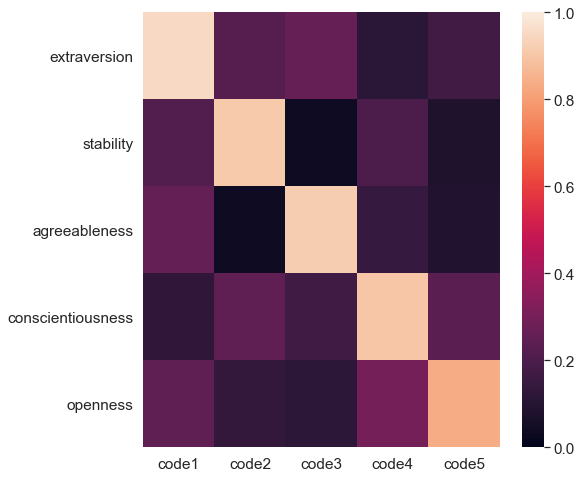

In [16]:
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.4)
tlabs = ['extraversion', 'stability', 'agreeableness', 'conscientiousness', 'openness']
nlabs = ['code' + str(i+1) for i in range(5)]
sns.heatmap(rmats,xticklabels=nlabs,yticklabels=tlabs,vmin=0.,vmax=1.)